# 10. Analyzing the Meaning of Sentences

## 10.1 Natural Language Understanding

In [1]:
import nltk
import re

In [2]:
nltk.data.show_cfg('grammars/book_grammars/sql0.fcfg')

% start S
S[SEM=(?np + WHERE + ?vp)] -> NP[SEM=?np] VP[SEM=?vp]
VP[SEM=(?v + ?pp)] -> IV[SEM=?v] PP[SEM=?pp]
VP[SEM=(?v + ?ap)] -> IV[SEM=?v] AP[SEM=?ap]
NP[SEM=(?det + ?n)] -> Det[SEM=?det] N[SEM=?n]
PP[SEM=(?p + ?np)] -> P[SEM=?p] NP[SEM=?np]
AP[SEM=?pp] -> A[SEM=?a] PP[SEM=?pp]
NP[SEM='Country="greece"'] -> 'Greece'
NP[SEM='Country="china"'] -> 'China'
Det[SEM='SELECT'] -> 'Which' | 'What'
N[SEM='City FROM city_table'] -> 'cities'
IV[SEM=''] -> 'are'
A[SEM=''] -> 'located'
P[SEM=''] -> 'in'


In [3]:
from nltk import load_parser
cp = load_parser('grammars/book_grammars/sql0.fcfg')
query = 'What cities are located in China'
trees = list(cp.parse(query.split()))
answer = trees[0].label()['SEM']
answer = [s for s in answer if s]
q = ' '.join(answer)
print(q)

SELECT City FROM city_table WHERE Country="china"


In [4]:
from nltk.sem import chat80
rows = chat80.sql_query('corpora/city_database/city.db', q)
for r in rows: 
    print(r[0], end=" ")

canton chungking dairen harbin kowloon mukden peking shanghai sian tientsin 

In [5]:
nltk.boolean_ops()

negation       	-
conjunction    	&
disjunction    	|
implication    	->
equivalence    	<->


In [7]:
read_expr = nltk.sem.Expression.fromstring
read_expr('-(P & Q)')

<NegatedExpression -(P & Q)>

In [8]:
read_expr('P & Q')

<AndExpression (P & Q)>

In [9]:
read_expr('P | (R -> Q)')

<OrExpression (P | (R -> Q))>

In [10]:
read_expr('P <-> -- P')

<IffExpression (P <-> --P)>

In [11]:
from nltk.sem import logic

In [13]:
SnF = read_expr('SnF')
NotFnS = read_expr('-FnS')
R = read_expr('SnF -> -FnS')
prover = nltk.Prover9()
prover.prove(NotFnS, [SnF, R])

True

In [14]:
val = nltk.Valuation([('P', True), ('Q', True), ('R', False)])
val['P']

True

In [15]:
dom = set()
g = nltk.Assignment(dom)
m = nltk.Model(dom, val)

In [16]:
print(m.evaluate('(P & Q)', g))

True


In [17]:
print(m.evaluate('-(P & Q)', g))

False


In [18]:
print(m.evaluate('(P & R)', g))

False


In [19]:
print(m.evaluate('(P | R)', g))

True


## 10.3 First-Order Logic

In [20]:
read_expr = nltk.sem.Expression.fromstring
expr = read_expr('walk(angus)', type_check=True)
expr.argument

<ConstantExpression angus>

In [21]:
expr.argument.type

e

In [22]:
expr.function

<ConstantExpression walk>

In [23]:
expr.function.type

<e,?>

In [24]:
sig = {'walk': '<e, t>'}
expr = read_expr('walk(angus)', signature=sig)
expr.function.type

e

In [25]:
read_expr = nltk.sem.Expression.fromstring
read_expr('dog(cyril)').free()


set()

In [26]:
read_expr('dog(x)').free()

{Variable('x')}

In [27]:
read_expr('own(angus, cyril)').free()

set()

In [28]:
read_expr('exists x.dog(x)').free()

set()

In [29]:
read_expr('((some x. walk(x)) -> sing(x))').free()

{Variable('x')}

In [30]:
read_expr('exists x.own(y, x)').free()

{Variable('y')}

In [31]:
NotFnS = read_expr('-north_of(f, s)')
SnF = read_expr('north_of(s, f)')
R = read_expr('all x. all y. (north_of(x, y) -> -north_of(y, x))')
prover = nltk.Prover9()
prover.prove(NotFnS, [SnF, R])

True

In [32]:
FnS = read_expr('north_of(f, s)')
prover.prove(FnS, [SnF, R])

False

In [33]:
dom = {'b', 'o', 'c'}

In [34]:
v = """
bertie => b
olive => o
cyril => c
boy => {b}
girl => {o}
dog => {c}
walk => {o, c}
see => {(b, o), (c, b), (o, c)}
"""
val = nltk.Valuation.fromstring(v)
print(val)

{'bertie': 'b',
 'boy': {('b',)},
 'cyril': 'c',
 'dog': {('c',)},
 'girl': {('o',)},
 'olive': 'o',
 'see': {('o', 'c'), ('b', 'o'), ('c', 'b')},
 'walk': {('c',), ('o',)}}


In [35]:
('o', 'c') in val['see']

True

In [36]:
('b',) in val['boy']

True

In [37]:
g = nltk.Assignment(dom, [('x', 'o'), ('y', 'c')])
g

{'x': 'o', 'y': 'c'}

In [38]:
print(g)

g[c/y][o/x]


In [39]:
m = nltk.Model(dom, val)
m.evaluate('see(olive, y)', g)

True

In [40]:
g['y']

'c'

In [41]:
m.evaluate('see(y, x)', g)

False

In [42]:
g.purge()
g

{}

In [43]:
m.evaluate('see(olive, y)', g)

'Undefined'

In [44]:
m.evaluate('see(bertie, olive) & boy(bertie) & -walk(bertie)', g)

True

In [45]:
m.evaluate('exists x.(girl(x) & walk(x))', g)

True

In [46]:
m.evaluate('girl(x) & walk(x)', g.add('x', 'o'))

True

In [47]:
fmla1 = read_expr('girl(x) | boy(x)')
m.satisfiers(fmla1, 'x', g)

{'b', 'o'}

In [48]:
fmla2 = read_expr('girl(x) -> walk(x)')
m.satisfiers(fmla2, 'x', g)

{'b', 'c', 'o'}

In [49]:
fmla3 = read_expr('walk(x) -> girl(x)')
m.satisfiers(fmla3, 'x', g)

{'b', 'o'}

In [50]:
m.evaluate('all x.(girl(x) -> walk(x))', g)

True

In [51]:
v2 = """
bruce => b
elspeth => e
julia => j
matthew => m
person => {b, e, j, m}
admire => {(j, b), (b, b), (m, e), (e, m)}
"""

In [52]:
val2 = nltk.Valuation.fromstring(v2)

In [53]:
dom2 = val2.domain
m2 = nltk.Model(dom2, val2)
g2 = nltk.Assignment(dom2)
fmla4 = read_expr('(person(x) -> exists y.(person(y) & admire(x, y)))')
m2.satisfiers(fmla4, 'x', g2)

{'b', 'e', 'j', 'm'}

In [54]:
fmla5 = read_expr('(person(y) & all x.(person(x) -> admire(x, y)))')
m2.satisfiers(fmla5, 'y', g2)

set()

In [55]:
fmla6 = read_expr('(person(y) & all x.((x = bruce | x = julia) -> admire(x, y)))')
m2.satisfiers(fmla6, 'y', g2)

{'b'}

In [56]:
a3 = read_expr('exists x.(man(x) & walks(x))')
c1 = read_expr('mortal(socrates)')
c2 = read_expr('-mortal(socrates)')
mb = nltk.Mace(5)
print(mb.build_model(None, [a3, c1]))

True


In [57]:
a4 = read_expr('exists y. (woman(y) & all x. (man(x) -> love(x,y)))')
a5 = read_expr('man(adam)')
a6 = read_expr('woman(eve)')
g = read_expr('love(adam,eve)')
mc = nltk.MaceCommand(g, assumptions=[a4, a5, a6])
mc.build_model()

True

In [58]:
print(mc.valuation)

{'C1': 'b',
 'adam': 'a',
 'eve': 'a',
 'love': {('a', 'b')},
 'man': {('a',)},
 'woman': {('b',), ('a',)}}


In [59]:
a7 = read_expr('all x. (man(x) -> -woman(x))')
g = read_expr('love(adam,eve)')
mc = nltk.MaceCommand(g, assumptions=[a4, a5, a6, a7])
mc.build_model()

True

In [60]:
print(mc.valuation)

{'C1': 'c',
 'adam': 'a',
 'eve': 'b',
 'love': {('a', 'c')},
 'man': {('a',)},
 'woman': {('b',), ('c',)}}


## 10.4 The Semantics of English Sentences

In [61]:
read_expr = nltk.sem.Expression.fromstring
expr = read_expr(r'\x.(walk(x) & chew_gum(x))')
expr

<LambdaExpression \x.(walk(x) & chew_gum(x))>

In [62]:
expr.free()

set()

In [63]:
print(read_expr(r'\x.(walk(x) & chew_gum(y))'))

\x.(walk(x) & chew_gum(y))


In [64]:
expr = read_expr(r'\x.(walk(x) & chew_gum(x))(gerald)')
print(expr)

\x.(walk(x) & chew_gum(x))(gerald)


In [65]:
print(expr.simplify())

(walk(gerald) & chew_gum(gerald))


In [66]:
print(read_expr(r'\x.\y.(dog(x) & own(y, x))(cyril)').simplify())

\y.(dog(cyril) & own(y,cyril))


In [67]:
print(read_expr(r'\x y.(dog(x) & own(y, x))(cyril, angus)').simplify())

(dog(cyril) & own(angus,cyril))


In [68]:
expr1 = read_expr('exists x.P(x)')
print(expr1)

exists x.P(x)


In [69]:
expr2 = expr1.alpha_convert(nltk.sem.Variable('z'))
print(expr2)

exists z.P(z)


In [70]:
expr1 == expr2

True

In [71]:
expr3 = read_expr('\P.(exists x.P(x))(\y.see(y, x))')
print(expr3)

(\P.exists x.P(x))(\y.see(y,x))


In [72]:
print(expr3.simplify())

exists z1.see(z1,x)


In [73]:
read_expr = nltk.sem.Expression.fromstring
tvp = read_expr(r'\X x.X(\y.chase(x,y))')
np = read_expr(r'(\P.exists x.(dog(x) & P(x)))')
vp = nltk.sem.ApplicationExpression(tvp, np)
print(vp)

(\X x.X(\y.chase(x,y)))(\P.exists x.(dog(x) & P(x)))


In [74]:
print(vp.simplify())

\x.exists z2.(dog(z2) & chase(x,z2))


In [75]:
from nltk import load_parser
parser = load_parser('grammars/book_grammars/simple-sem.fcfg', trace=0)
sentence = 'Angus gives a bone to every dog'
tokens = sentence.split()
for tree in parser.parse(tokens):
    print(tree.label()['SEM'])

all z4.(dog(z4) -> exists z3.(bone(z3) & give(angus,z3,z4)))


In [76]:
sents = ['Irene walks', 'Cyril bites an ankle']
grammar_file = 'grammars/book_grammars/simple-sem.fcfg'
for results in nltk.interpret_sents(sents, grammar_file):
    for (synrep, semrep) in results:
        print(synrep)

(S[SEM=<walk(irene)>]
  (NP[-LOC, NUM='sg', SEM=<\P.P(irene)>]
    (PropN[-LOC, NUM='sg', SEM=<\P.P(irene)>] Irene))
  (VP[NUM='sg', SEM=<\x.walk(x)>]
    (IV[NUM='sg', SEM=<\x.walk(x)>, TNS='pres'] walks)))
(S[SEM=<exists z5.(ankle(z5) & bite(cyril,z5))>]
  (NP[-LOC, NUM='sg', SEM=<\P.P(cyril)>]
    (PropN[-LOC, NUM='sg', SEM=<\P.P(cyril)>] Cyril))
  (VP[NUM='sg', SEM=<\x.exists z5.(ankle(z5) & bite(x,z5))>]
    (TV[NUM='sg', SEM=<\X x.X(\y.bite(x,y))>, TNS='pres'] bites)
    (NP[NUM='sg', SEM=<\Q.exists x.(ankle(x) & Q(x))>]
      (Det[NUM='sg', SEM=<\P Q.exists x.(P(x) & Q(x))>] an)
      (Nom[NUM='sg', SEM=<\x.ankle(x)>]
        (N[NUM='sg', SEM=<\x.ankle(x)>] ankle)))))


In [77]:
v = """
bertie => b
olive => o
cyril => c
boy => {b}
girl => {o}
dog => {c}
walk => {o, c}
see => {(b, o), (c, b), (o, c)}
"""

In [78]:
val = nltk.Valuation.fromstring(v)
g = nltk.Assignment(val.domain)
m = nltk.Model(val.domain, val)
sent = 'Cyril sees every boy'
grammar_file = 'grammars/book_grammars/simple-sem.fcfg'
results = nltk.evaluate_sents([sent], grammar_file, m, g)[0]
for (syntree, semrep, value) in results:
    print(semrep)
    print(value)

all z6.(boy(z6) -> see(cyril,z6))
True


In [79]:
from nltk.sem import cooper_storage as cs
sentence = 'every girl chases a dog'
trees = cs.parse_with_bindops(sentence, grammar='grammars/book_grammars/storage.fcfg')
semrep = trees[0].label()['SEM']
cs_semrep = cs.CooperStore(semrep)
print(cs_semrep.core)

chase(z2,z3)


In [80]:
for bo in cs_semrep.store:
    print(bo)

bo(\P.all x.(girl(x) -> P(x)),z2)
bo(\P.exists x.(dog(x) & P(x)),z3)


In [81]:
cs_semrep.s_retrieve(trace=True)

Permutation 1
   (\P.all x.(girl(x) -> P(x)))(\z2.chase(z2,z3))
   (\P.exists x.(dog(x) & P(x)))(\z3.all x.(girl(x) -> chase(x,z3)))
Permutation 2
   (\P.exists x.(dog(x) & P(x)))(\z3.chase(z2,z3))
   (\P.all x.(girl(x) -> P(x)))(\z2.exists x.(dog(x) & chase(z2,x)))


In [82]:
for reading in cs_semrep.readings:
    print(reading)

exists x.(dog(x) & all z9.(girl(z9) -> chase(z9,x)))
all x.(girl(x) -> exists z10.(dog(z10) & chase(x,z10)))


## 10.5 Discourse Semantics

In [83]:
read_dexpr = nltk.sem.DrtExpression.fromstring
drs1 = read_dexpr('([x, y], [angus(x), dog(y), own(x, y)])')
print(drs1)

([x,y],[angus(x), dog(y), own(x,y)])


In [84]:
drs1.draw()

In [85]:
print(drs1.fol())

exists x y.(angus(x) & dog(y) & own(x,y))


In [86]:
drs2 = read_dexpr('([x], [walk(x)]) + ([y], [run(y)])')
print(drs2)

(([x],[walk(x)]) + ([y],[run(y)]))


In [87]:
print(drs2.simplify())

([x,y],[walk(x), run(y)])


In [88]:
drs3 = read_dexpr('([], [(([x], [dog(x)]) -> ([y],[ankle(y), bite(x, y)]))])')
print(drs3.fol())

all x.(dog(x) -> exists y.(ankle(y) & bite(x,y)))


In [89]:
drs4 = read_dexpr('([x, y], [angus(x), dog(y), own(x, y)])')
drs5 = read_dexpr('([u, z], [PRO(u), irene(z), bite(u, z)])')
drs6 = drs4 + drs5
print(drs6.simplify())

([u,x,y,z],[angus(x), dog(y), own(x,y), PRO(u), irene(z), bite(u,z)])


In [90]:
print(drs6.simplify().resolve_anaphora())

([u,x,y,z],[angus(x), dog(y), own(x,y), (u = [x,y,z]), irene(z), bite(u,z)])


In [91]:
from nltk import load_parser
parser = load_parser('grammars/book_grammars/drt.fcfg', logic_parser=nltk.sem.drt.DrtParser())
trees = list(parser.parse('Angus owns a dog'.split()))
print(trees[0].label()['SEM'].simplify())

([x,z13],[Angus(x), dog(z13), own(x,z13)])


In [92]:
dt = nltk.DiscourseTester(['A student dances', 'Every student is a person'])
dt.readings()


s0 readings:

s0-r0: exists z1.(student(z1) & dance(z1))

s1 readings:

s1-r0: all z1.(student(z1) -> person(z1))


In [93]:
dt.add_sentence('No person dances', consistchk=True)

Inconsistent discourse: d0 ['s0-r0', 's1-r0', 's2-r0']:
    s0-r0: exists z1.(student(z1) & dance(z1))
    s1-r0: all z1.(student(z1) -> person(z1))
    s2-r0: -exists z1.(person(z1) & dance(z1))



In [94]:
dt.retract_sentence('No person dances', verbose=True)

Current sentences are 
s0: A student dances
s1: Every student is a person


In [95]:
dt.add_sentence('A person dances', informchk=True)

Sentence 'A person dances' under reading 'exists x.(person(x) & dance(x))':
Not informative relative to thread 'd0'


In [96]:
from nltk.tag import RegexpTagger
tagger = RegexpTagger(
    [('^(chases|runs)$', 'VB'),
    ('^(a)$', 'ex_quant'),
    ('^(every)$', 'univ_quant'),
    ('^(dog|boy)$', 'NN'),
    ('^(He)$', 'PRP')
    ])

In [97]:
rc = nltk.DrtGlueReadingCommand(semtype_file='grammars/sample_grammars/drt_glue.semtype', 
    depparser=nltk.MaltParser('/pub/nltk-parser/', '/pub/nltk-parser/engmalt.linear-1.7.mco', tagger=tagger.tag))
dt = nltk.DiscourseTester(['Every dog chases a boy', 'He runs'], rc)
dt.readings()

TypeError: sequence item 3: expected str instance, NoneType found

In [99]:
import nltk
from nltk.parse.malt import MaltParser 
from nltk.inference.discourse import DrtGlueReadingCommand

In [100]:
from nltk import pos_tag
mparser = MaltParser('/pub/nltk-parser/', '/pub/nltk-parser/engmalt.linear-1.7.mco', tagger=pos_tag)
rc = DrtGlueReadingCommand(depparser=mparser)
dt = nltk.DiscourseTester(['Every dog chases a boy', 'He runs'], rc)
dt.readings()

AssertionError: 

In [102]:
dt.readings(show_thread_readings=True)

AssertionError: 

In [103]:
dt.readings(show_thread_readings=True, filter=True)

AssertionError: 

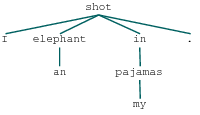

In [101]:
mparser = MaltParser('/pub/nltk-parser/', '/pub/nltk-parser/engmalt.linear-1.7.mco')
mparser.parse_one('I shot an elephant in my pajamas .'.split()).tree()